<h1>モジュールのインストール</h1>

In [1]:
!pip install torch torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

<h1>データの準備</h1>

In [2]:
import torch
import torchvision
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])



train_dataset = torchvision.datasets. CIFAR10(
    './cifar-10', train=True, download=True,
    transform=transform_train)


test_data = torchvision.datasets. CIFAR10(
    './cifar-10', train=False, download=True,
    transform=transform_test)

# train_dataをshuffleしてから分割

train_data, val_data = torch.utils.data.random_split(train_dataset, [45000, 5000])

train_loader = torch.utils.data.DataLoader(train_data,  batch_size=128, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170498071/170498071 [00:02<00:00, 72018624.31it/s]


Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10
Files already downloaded and verified


<h1>Res Net 20 アーキテクチャ</h1>

In [3]:
#シードの固定

torch.manual_seed(4931)

def identity(x,channels):
        
    x = F.interpolate(x, size=(x.size(2)//2, x.size(3)//2), mode='nearest')
        
    #テンソルの次元は [batch_size, channels, x , yの順番]
        
    zero_padding = torch.zeros(x.size(0),channels,x.size(2),x.size(3), device = device)
    
    x = torch.cat((x,zero_padding), dim = 1)
        
    return x
    


class ResNet20(nn.Module):
    def __init__(self):
        super(ResNet20, self).__init__()
        # Input size: [batch_size, 3, 32, 32] -> Output Size : [batch_size, 16, 32, 32]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size= 3, padding = 1)

        self.bn1 = nn.BatchNorm2d(16)

        # Input size: [batch_size, 16, 32, 32] -> Output Size : [batch_size, 16, 32, 32]
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)

        self.bn2_1 = nn.BatchNorm2d(16)
        self.bn2_2 = nn.BatchNorm2d(16)
        self.bn2_3 = nn.BatchNorm2d(16)
        self.bn2_4 = nn.BatchNorm2d(16)
        self.bn2_5 = nn.BatchNorm2d(16)
        self.bn2_6 = nn.BatchNorm2d(16)

        # Input size: [batch_size, 16, 32, 32] -> Output Size : [batch_size, 32, 16, 16]
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1,stride = 2)

        self.bn3 = nn.BatchNorm2d(32)
        
        

        # Input size: [batch_size, 32, 16, 16] -> Output Size : [batch_size, 32, 16, 16]
        self.conv4_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_2= nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.bn4_1 = nn.BatchNorm2d(32)
        self.bn4_2 = nn.BatchNorm2d(32)
        self.bn4_3 = nn.BatchNorm2d(32)
        self.bn4_4 = nn.BatchNorm2d(32)
        self.bn4_5 = nn.BatchNorm2d(32)


        # Input size: [batch_size, 32, 16, 16] -> Output Size : [batch_size, 64, 8, 8]
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride = 2)

        self.bn5 = nn.BatchNorm2d(64)

        # Input size: [batch_size, 64, 8, 8] -> Output Size : [batch_size, 64, 8, 8]
        self.conv6_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)


        self.bn6_1 = nn.BatchNorm2d(64)
        self.bn6_2 = nn.BatchNorm2d(64)
        self.bn6_3 = nn.BatchNorm2d(64)
        self.bn6_4 = nn.BatchNorm2d(64)



        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        # Size after pooling: [batch_size, 64, 1, 1]

        self.fc = nn.Linear(in_features=64, out_features=10)
        
        
    


    def forward(self, x):

        x_1 = F.relu(self.bn1(self.conv1(x)))

        x_2 = F.relu(self.bn2_1(self.conv2_1(x_1)))
        x_3 = F.relu(self.bn2_2(self.conv2_2(x_2)) + x_1)
        
        x_4 = F.relu(self.bn2_3(self.conv2_3(x_3)))
        x_5 = F.relu(self.bn2_4(self.conv2_4(x_4)) + x_3)
        
        x_6 = F.relu(self.bn2_5(self.conv2_5(x_5)))
        x_7 = F.relu(self.bn2_6(self.conv2_6(x_6))+ x_5)
        

        
        x_8 = F.relu(self.bn3(self.conv3(x_7)))
        x_9 = F.relu(self.bn4_1(self.conv4_1(x_8))+ identity(x = x_7,channels = 16)) #恒等写像A
        
        
        x_10 = F.relu(self.bn4_2(self.conv4_2(x_9)))
        x_11 = F.relu(self.bn4_3(self.conv4_3(x_10)) + x_9)
        
        x_12 = F.relu(self.bn4_4(self.conv4_4(x_11)))
        x_13 = F.relu(self.bn4_5(self.conv4_5(x_12)) + x_11)


        x_14 = F.relu(self.bn5(self.conv5(x_13))) 
        x_15 = F.relu(self.bn6_1(self.conv6_1(x_14)) + identity(x = x_13,channels = 32)) #恒等写像A
        
        
        x_16 = F.relu(self.bn6_2(self.conv6_2(x_15)))
        x_17 = F.relu(self.bn6_3(self.conv6_3(x_16)) + x_15)
        
        x_18 = F.relu(self.bn6_4(self.conv6_4(x_17)))
        x_19 = F.relu(self.conv6_5(x_18) + x_17)

        x_19 = self.avgpool(x_19)

        x_19 = x_19.view(-1, 64)
        x = self.fc(x_19)

        return x



# Instantiate the network
res_net20 = ResNet20()

# データ並列学習 ON

res_net20.to(device)

res_net20 = nn.DataParallel(res_net20)





<h1>Res Net 56 アーキテクチャ</h1>

In [4]:
#シードの固定

torch.manual_seed(4931)


class ResNet56(nn.Module):
    def __init__(self):
        super(ResNet56, self).__init__()
        # Input size: [batch_size, 3, 32, 32] -> Output Size : [batch_size, 16, 32, 32]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size= 3, padding = 1)

        self.bn1 = nn.BatchNorm2d(16)

        # Input size: [batch_size, 16, 32, 32] -> Output Size : [batch_size, 16, 32, 32]
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_7 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_9 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_10 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_11 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_12 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_13 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_14 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_15 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_16 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_17 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_18 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)

        self.bn2_1 = nn.BatchNorm2d(16)
        self.bn2_2 = nn.BatchNorm2d(16)
        self.bn2_3 = nn.BatchNorm2d(16)
        self.bn2_4 = nn.BatchNorm2d(16)
        self.bn2_5 = nn.BatchNorm2d(16)
        self.bn2_6 = nn.BatchNorm2d(16)
        self.bn2_7 = nn.BatchNorm2d(16)
        self.bn2_8 = nn.BatchNorm2d(16)
        self.bn2_9 = nn.BatchNorm2d(16)
        self.bn2_10 = nn.BatchNorm2d(16)
        self.bn2_11 = nn.BatchNorm2d(16)
        self.bn2_12 = nn.BatchNorm2d(16)
        self.bn2_13 = nn.BatchNorm2d(16)
        self.bn2_14 = nn.BatchNorm2d(16)
        self.bn2_15 = nn.BatchNorm2d(16)
        self.bn2_16 = nn.BatchNorm2d(16)
        self.bn2_17 = nn.BatchNorm2d(16)
        self.bn2_18 = nn.BatchNorm2d(16)

        # Input size: [batch_size, 16, 32, 32] -> Output Size : [batch_size, 32, 16, 16]
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1,stride = 2)

        self.bn3 = nn.BatchNorm2d(32)

        # Input size: [batch_size, 32, 16, 16] -> Output Size : [batch_size, 32, 16, 16]
        self.conv4_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_2= nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_7= nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_8 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_9 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_10 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_11 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_12= nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_13 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_15 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_16 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4_17 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)


        self.bn4_1 = nn.BatchNorm2d(32)
        self.bn4_2 = nn.BatchNorm2d(32)
        self.bn4_3 = nn.BatchNorm2d(32)
        self.bn4_4 = nn.BatchNorm2d(32)
        self.bn4_5 = nn.BatchNorm2d(32)
        self.bn4_6 = nn.BatchNorm2d(32)
        self.bn4_7 = nn.BatchNorm2d(32)
        self.bn4_8 = nn.BatchNorm2d(32)
        self.bn4_9 = nn.BatchNorm2d(32)
        self.bn4_10 = nn.BatchNorm2d(32)
        self.bn4_11 = nn.BatchNorm2d(32)
        self.bn4_12 = nn.BatchNorm2d(32)
        self.bn4_13 = nn.BatchNorm2d(32)
        self.bn4_14 = nn.BatchNorm2d(32)
        self.bn4_15 = nn.BatchNorm2d(32)
        self.bn4_16 = nn.BatchNorm2d(32)
        self.bn4_17 = nn.BatchNorm2d(32)


        # Input size: [batch_size, 32, 16, 16] -> Output Size : [batch_size, 64, 8, 8]
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride = 2)

        self.bn5 = nn.BatchNorm2d(64)

        # Input size: [batch_size, 64, 8, 8] -> Output Size : [batch_size, 64, 8, 8]
        self.conv6_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_11 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_13 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_14 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_15 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_16 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv6_17 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)


        self.bn6_1 = nn.BatchNorm2d(64)
        self.bn6_2 = nn.BatchNorm2d(64)
        self.bn6_3 = nn.BatchNorm2d(64)
        self.bn6_4 = nn.BatchNorm2d(64)
        self.bn6_5 = nn.BatchNorm2d(64)
        self.bn6_6 = nn.BatchNorm2d(64)
        self.bn6_7 = nn.BatchNorm2d(64)
        self.bn6_8 = nn.BatchNorm2d(64)
        self.bn6_9 = nn.BatchNorm2d(64)
        self.bn6_10 = nn.BatchNorm2d(64)
        self.bn6_11 = nn.BatchNorm2d(64)
        self.bn6_12 = nn.BatchNorm2d(64)
        self.bn6_13 = nn.BatchNorm2d(64)
        self.bn6_14 = nn.BatchNorm2d(64)
        self.bn6_15 = nn.BatchNorm2d(64)
        self.bn6_16 = nn.BatchNorm2d(64)


        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        # Size after pooling: [batch_size, 64, 1, 1]

        self.fc = nn.Linear(in_features=64, out_features=10)
        

    def forward(self, x):
    
        x_1 = F.relu(self.bn1(self.conv1(x)))

        x_2 = F.relu(self.bn2_1(self.conv2_1(x_1)))
        x_3 = F.relu(self.bn2_2(self.conv2_2(x_2)) + x_1)
        
        x_4 = F.relu(self.bn2_3(self.conv2_3(x_3)))
        x_5 = F.relu(self.bn2_4(self.conv2_4(x_4)) + x_3)
        
        x_6 = F.relu(self.bn2_5(self.conv2_5(x_5)))
        x_7 = F.relu(self.bn2_6(self.conv2_6(x_6)) + x_5)
        
        x_8 = F.relu(self.bn2_7(self.conv2_7(x_7)))
        x_9 = F.relu(self.bn2_8(self.conv2_8(x_8) + x_7))
        
        x_10 = F.relu(self.bn2_9(self.conv2_9(x_9)))
        x_11 = F.relu(self.bn2_10(self.conv2_10(x_10)+ x_9))
        
        x_12 = F.relu(self.bn2_11(self.conv2_11(x_11)))
        x_13 = F.relu(self.bn2_12(self.conv2_12(x_12)+ x_11))
        
        x_14 = F.relu(self.bn2_13(self.conv2_13(x_13)))
        x_15 = F.relu(self.bn2_14(self.conv2_14(x_14)+ x_13))
        
        x_16 = F.relu(self.bn2_15(self.conv2_15(x_15)))
        x_17 = F.relu(self.bn2_16(self.conv2_16(x_16)+ x_15))
        
        x_18 = F.relu(self.bn2_17(self.conv2_17(x_17)))
        x_19 = F.relu(self.bn2_18(self.conv2_18(x_18)+ x_17))

        
        x_20 = F.relu(self.bn3(self.conv3(x_19)))
        x_21 = F.relu(self.bn4_1(self.conv4_1(x_20))+ identity(x = x_19,channels = 16))
              
            
        x_22 = F.relu(self.bn4_2(self.conv4_2(x_21)))
        x_23 = F.relu(self.bn4_3(self.conv4_3(x_22)) + x_21)
        
        x_24 = F.relu(self.bn4_4(self.conv4_4(x_23)))
        x_25 = F.relu(self.bn4_5(self.conv4_5(x_24)) + x_23)
        
        x_26 = F.relu(self.bn4_6(self.conv4_6(x_25)))
        x_27 = F.relu(self.bn4_7(self.conv4_7(x_26)) + x_25)
        
        x_28 = F.relu(self.bn4_8(self.conv4_8(x_27)))
        x_29 = F.relu(self.bn4_9(self.conv4_9(x_28) + x_27))
        
        
        x_30 = F.relu(self.bn4_10(self.conv4_10(x_29)))
        x_31 = F.relu(self.bn4_11(self.conv4_11(x_30)+ x_29))
        
        x_32 = F.relu(self.bn4_12(self.conv4_12(x_31)))
        x_33 = F.relu(self.bn4_13(self.conv4_13(x_32)+ x_31))
        
        x_34 = F.relu(self.bn4_14(self.conv4_14(x_33)))
        x_35 = F.relu(self.bn4_15(self.conv4_15(x_34)+ x_33))
        
        x_36 = F.relu(self.bn4_16(self.conv4_16(x_35)))
        x_37 = F.relu(self.bn4_17(self.conv4_17(x_36)+ x_35))
        
        x_38 = F.relu(self.bn5(self.conv5(x_37)))
        x_39 = F.relu(self.bn6_1(self.conv6_1(x_38))+ identity(x = x_37,channels = 32))
        
        x_40 = F.relu(self.bn6_2(self.conv6_2(x_39)))
        x_41 = F.relu(self.bn6_3(self.conv6_3(x_40)+ x_39))
        
        x_42 = F.relu(self.bn6_4(self.conv6_4(x_41)))
        x_43 = F.relu(self.bn6_5(self.conv6_5(x_42)+ x_41))
        
        x_44 = F.relu(self.bn6_6(self.conv6_6(x_43)))
        x_45 = F.relu(self.bn6_7(self.conv6_7(x_44)+ x_43))
        
        x_46 = F.relu(self.bn6_8(self.conv6_8(x_45)))
        x_47 = F.relu(self.bn6_9(self.conv6_9(x_46)+ x_45))
        
        x_48 = F.relu(self.bn6_10(self.conv6_10(x_47)))
        x_49 = F.relu(self.bn6_11(self.conv6_11(x_48)+ x_47))
        
        x_50 = F.relu(self.bn6_12(self.conv6_12(x_49)))
        x_51 = F.relu(self.bn6_13(self.conv6_13(x_50)+ x_49))
        
        x_52 = F.relu(self.bn6_14(self.conv6_14(x_51)))
        x_53 = F.relu(self.bn6_15(self.conv6_15(x_52)+ x_51))
        
        x_54 = F.relu(self.bn6_16(self.conv6_16(x_53)))


        x_55 = F.relu(self.conv6_17(x_54))

        x_55 = self.avgpool(x_55)

        x_55 = x_55.view(-1, 64)
        x = self.fc(x_55)

        return x

# Instantiate the network
res_net56 = ResNet56()



# データ並列学習 ON
res_net56.to(device)

res_net56 = nn.DataParallel(res_net56)



<h1>損失関数の定義</h1>

In [5]:
# 交差エントロピー
criterion = nn.CrossEntropyLoss()
# 確率的勾配降下法
optimizer_20 = optim.SGD(res_net20.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.0001)
optimizer_56 = optim.SGD(res_net56.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.0001)

<h1>Res Net 20 学習</h1>

In [6]:
num_epochs = 182

train_losses_20 = []
val_losses_20 = []
train_accuracies_20 = []
val_accuracies_20 = []

train_losses_56 = []
val_losses_56 = []
train_accuracies_56 = []
val_accuracies_56 = []


## Train Res Net 20

t0 = time.time()

for epoch in range(num_epochs):
    # Training
    res_net20.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    if num_epochs == 92:

        optimizer_20 = optim.SGD(res_net20.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0001)


    for data in train_loader:                                     #enumerateでバッチに番号を振り、iでそれを引っ張ってくる。dataは一個ずつ引っ張り出してくるのではなく一気にバッチで学習する。
        inputs, labels = data                                     #画像データ,正解ラベルのペアになっているのを分解
        inputs, labels = inputs.to(device), labels.to(device)     #GPUに載せる
        optimizer_20.zero_grad()                                     #勾配を0に設定
        outputs = res_net20(inputs)                                     #インスタンス化したモデルに、入力を加えることで主力を得る
        loss = criterion(outputs, labels)                         #指定した損失関数から損失を得る。この時点ではテンソルであることに注意。
        loss.backward()                                           #得た損失のテンソルから勾配を計算
        optimizer_20.step()                                          #得た勾配からパラメータを更新

        running_loss += loss.item()                               #各データの損失を、テンソルから普通の数字(フロート)に変換し、epochごとの損失を得るために足し合わせる。
        _, predicted = torch.max(outputs.data, 1)                 # 1:データの各クラス間 の最大値を、確率とその値を返す。
        total_train += labels.size(0)                             # バッチに含まれているデータの数を継ぎ足す。
        correct_train += (predicted == labels).sum().item()       # 正解した分のみを正答数に継ぎ足す。

    train_losses_20.append(running_loss / len(train_loader))         # epochごとに、平均損失リストに加えていく。
    train_accuracies_20.append(100 * correct_train / total_train)    # epochごとに正答率リストに加えていく。

    # Validation
    res_net20.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = res_net20(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses_20.append(val_loss / len(val_loader))
    val_accuracies_20.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss: {train_losses_20[-1]:.3f}, Training accuracy: {train_accuracies_20[-1]:.3f}%')
    print(f'Validation loss: {val_losses_20[-1]:.3f}, Validation accuracy: {val_accuracies_20[-1]:.3f}%')

print('Res Net 20 Finished Training')
print("Training time(seconds):", time.time()-t0)




Epoch 1/182
Training loss: 1.521, Training accuracy: 43.564%
Validation loss: 1.293, Validation accuracy: 54.660%
Epoch 2/182
Training loss: 1.063, Training accuracy: 61.960%
Validation loss: 1.294, Validation accuracy: 57.360%
Epoch 3/182
Training loss: 0.846, Training accuracy: 70.242%
Validation loss: 0.795, Validation accuracy: 72.060%
Epoch 4/182
Training loss: 0.706, Training accuracy: 75.133%
Validation loss: 0.932, Validation accuracy: 68.000%
Epoch 5/182
Training loss: 0.620, Training accuracy: 78.429%
Validation loss: 0.737, Validation accuracy: 74.580%
Epoch 6/182
Training loss: 0.563, Training accuracy: 80.436%
Validation loss: 0.638, Validation accuracy: 77.800%
Epoch 7/182
Training loss: 0.507, Training accuracy: 82.478%
Validation loss: 0.565, Validation accuracy: 80.320%
Epoch 8/182
Training loss: 0.477, Training accuracy: 83.538%
Validation loss: 0.665, Validation accuracy: 78.280%
Epoch 9/182
Training loss: 0.443, Training accuracy: 84.682%
Validation loss: 0.620, Val

<h1>Res Net 56 学習</h1>

In [7]:
## Train Res Net 56

t0 = time.time()

for epoch in range(num_epochs):
    # Training
    res_net56.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    if num_epochs == 92:

        optimizer_56 = optim.SGD(res_net56.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0001)


    for data in train_loader:                                     #enumerateでバッチに番号を振り、iでそれを引っ張ってくる。dataは一個ずつ引っ張り出してくるのではなく一気にバッチで学習する。
        inputs, labels = data                                     #画像データ,正解ラベルのペアになっているのを分解
        inputs, labels = inputs.to(device), labels.to(device)     #GPUに載せる
        optimizer_56.zero_grad()                                     #勾配を0に設定
        outputs = res_net56(inputs)                                     #インスタンス化したモデルに、入力を加えることで主力を得る
        loss = criterion(outputs, labels)                         #指定した損失関数から損失を得る。この時点ではテンソルであることに注意。
        loss.backward()                                           #得た損失のテンソルから勾配を計算
        optimizer_56.step()                                          #得た勾配からパラメータを更新

        running_loss += loss.item()                               #各データの損失を、テンソルから普通の数字(フロート)に変換し、epochごとの損失を得るために足し合わせる。
        _, predicted = torch.max(outputs.data, 1)                 # 1:データの各クラス間 の最大値を、確率とその値を返す。
        total_train += labels.size(0)                             # バッチに含まれているデータの数を継ぎ足す。
        correct_train += (predicted == labels).sum().item()       # 正解した分のみを正答数に継ぎ足す。

    train_losses_56.append(running_loss / len(train_loader))         # epochごとに、平均損失リストに加えていく。
    train_accuracies_56.append(100 * correct_train / total_train)    # epochごとに正答率リストに加えていく。

    # Validation
    res_net56.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = res_net56(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses_56.append(val_loss / len(val_loader))
    val_accuracies_56.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss: {train_losses_56[-1]:.3f}, Training accuracy: {train_accuracies_56[-1]:.3f}%')
    print(f'Validation loss: {val_losses_56[-1]:.3f}, Validation accuracy: {val_accuracies_56[-1]:.3f}%')

print('Plain Net 56 Finished Training')
print("Training time(seconds):", time.time()-t0)

Epoch 1/182
Training loss: 1.773, Training accuracy: 31.882%
Validation loss: 1.585, Validation accuracy: 41.260%
Epoch 2/182
Training loss: 1.303, Training accuracy: 52.798%
Validation loss: 1.153, Validation accuracy: 59.220%
Epoch 3/182
Training loss: 0.995, Training accuracy: 64.578%
Validation loss: 0.908, Validation accuracy: 67.400%
Epoch 4/182
Training loss: 0.796, Training accuracy: 72.378%
Validation loss: 0.714, Validation accuracy: 74.560%
Epoch 5/182
Training loss: 0.673, Training accuracy: 76.673%
Validation loss: 0.766, Validation accuracy: 73.900%
Epoch 6/182
Training loss: 0.593, Training accuracy: 79.742%
Validation loss: 0.683, Validation accuracy: 77.400%
Epoch 7/182
Training loss: 0.527, Training accuracy: 81.796%
Validation loss: 0.597, Validation accuracy: 80.080%
Epoch 8/182
Training loss: 0.473, Training accuracy: 83.756%
Validation loss: 0.691, Validation accuracy: 78.220%
Epoch 9/182
Training loss: 0.436, Training accuracy: 85.102%
Validation loss: 0.528, Val

<h1>結果のプロット</h1>

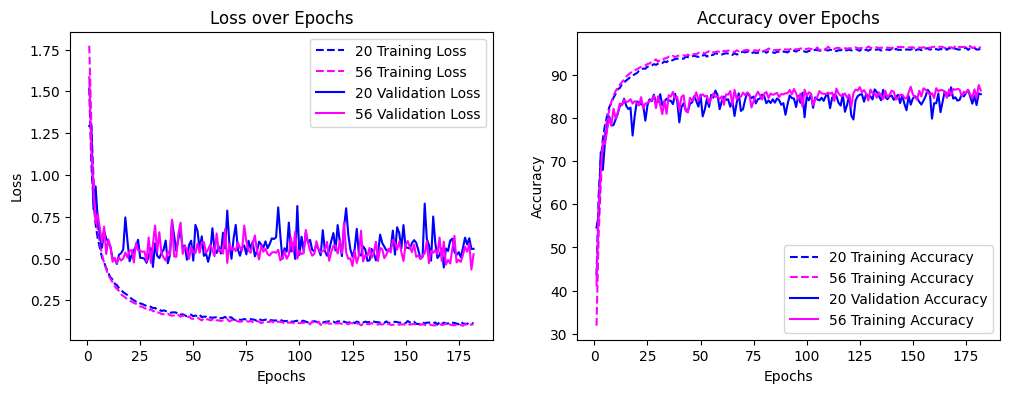

In [8]:

# Plot the training and validation loss
plt.figure(figsize=(12, 4))                                              # 横12インチ、縦4インチのグラフを作成
plt.subplot(1, 2, 1)                                                     # 1行 2列にグラフを表示、最初に左からグラフをプロットする。
plt.plot(range(1, num_epochs+1), train_losses_20, label='20 Training Loss', color = 'blue', linestyle = 'dashed')
plt.plot(range(1, num_epochs+1), train_losses_56,label='56 Training Loss' , color = 'magenta', linestyle = 'dashed')
plt.plot(range(1, num_epochs+1), val_losses_20,label='20 Validation Loss' , color = 'blue')
plt.plot(range(1, num_epochs+1), val_losses_56 ,label='56 Validation Loss', color = 'magenta')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies_20, label='20 Training Accuracy', color = 'blue', linestyle = 'dashed')
plt.plot(range(1, num_epochs+1), train_accuracies_56,  label='56 Training Accuracy', color = 'magenta', linestyle = 'dashed')
plt.plot(range(1, num_epochs+1), val_accuracies_20, label='20 Validation Accuracy', color = 'blue')
plt.plot(range(1, num_epochs+1), val_accuracies_56, label='56 Training Accuracy', color = 'magenta')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()